In [1]:
%%capture
%run 02_FeatEng.ipynb

In [2]:
import mle.tsa as mle_tsa

Importing plotly failed. Interactive plots will not work.


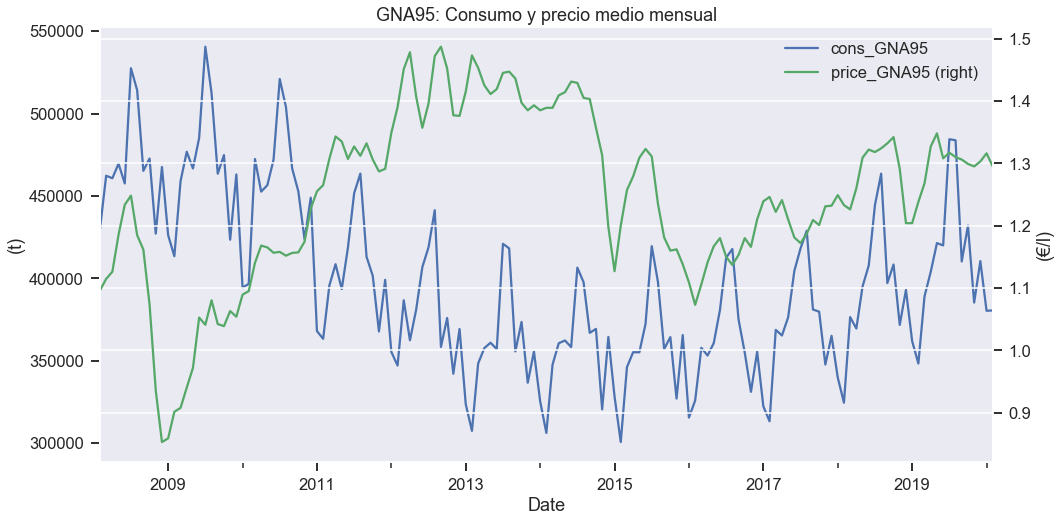

In [37]:
ax = data.plot(y=['cons_GNA95', 'price_GNA95'], secondary_y='price_GNA95')
ax.set_ylabel('(t)')
ax.right_ax.set_ylabel("(€/l)")
plt.title('GNA95: Consumo y precio medio mensual')
plt.show()

# Seasonality Analysis

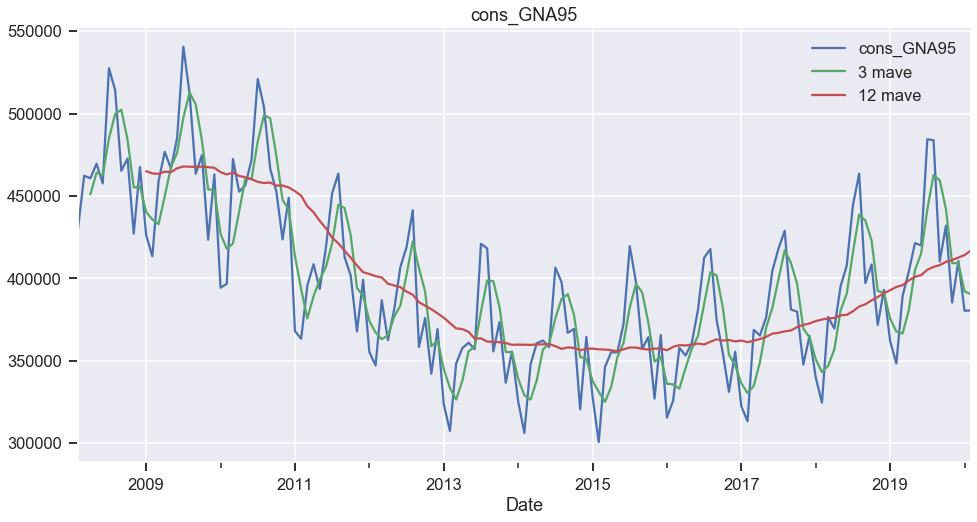

In [20]:
ax = mle_tsa.plot_time_series_maves(x=data['cons_GNA95'], periods=[3,12])

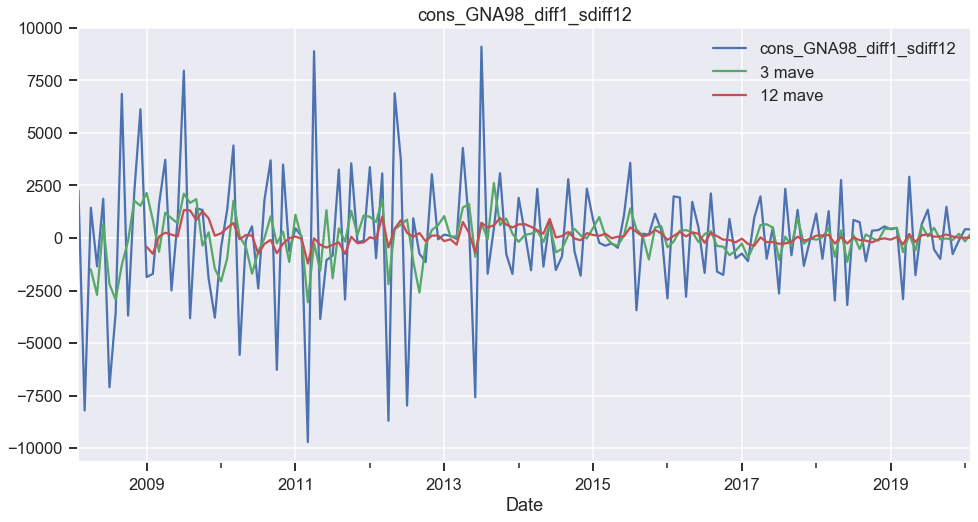

In [9]:
ax = mle_tsa.plot_time_series_maves(x=data['cons_GNA98_diff1_sdiff12'], periods=[3,12])

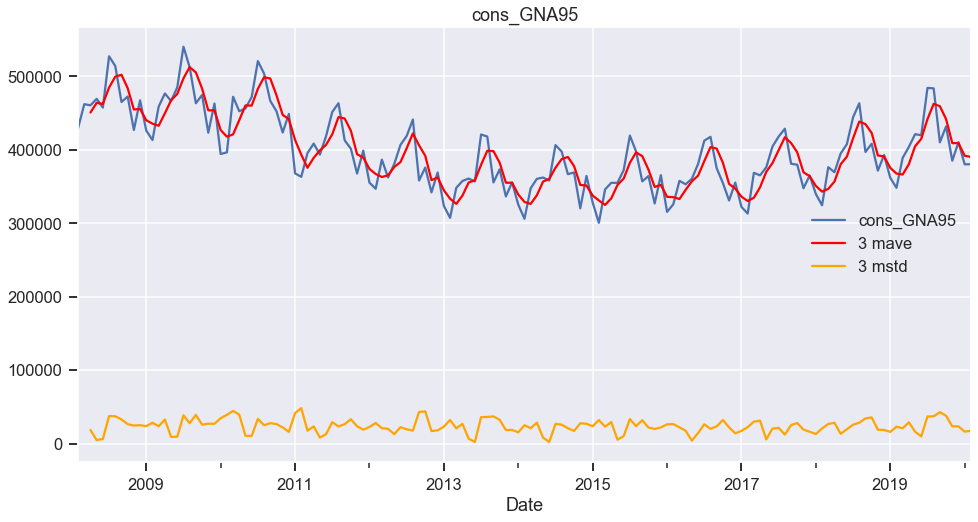

In [10]:
ax = mle_tsa.plot_time_series_with_rolling(x=data['cons_GNA95'], period=3)

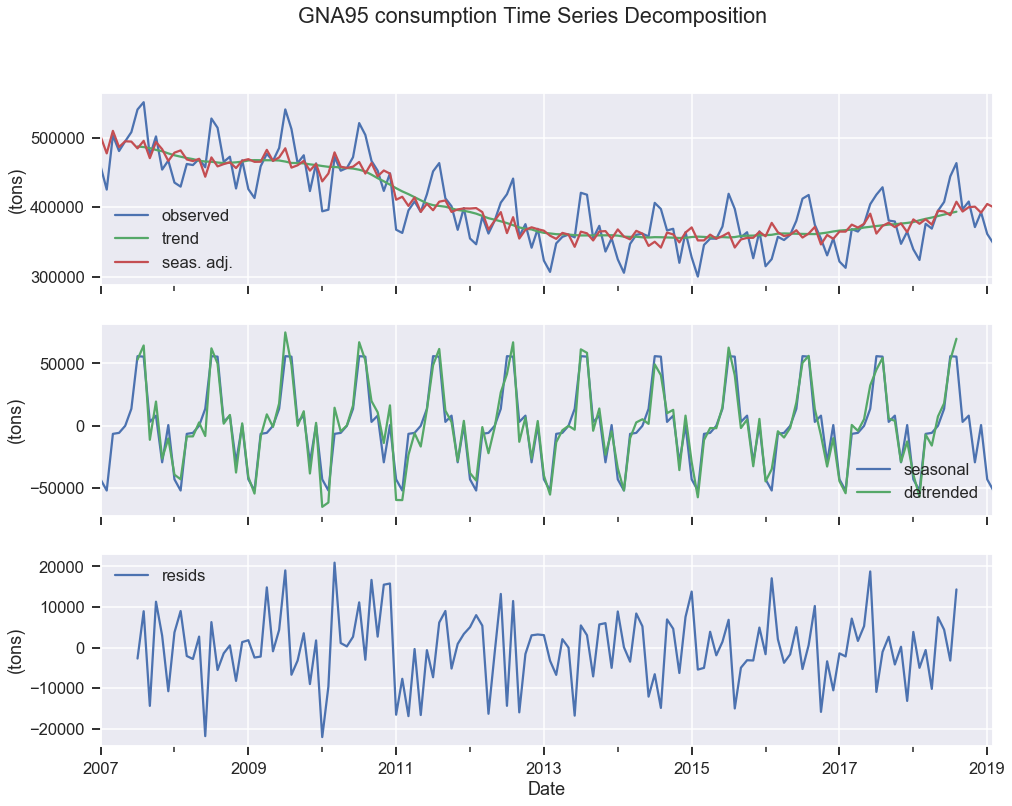

In [11]:
fig, axs = mle_tsa.plot_seas_model(seas_models['cons_GNA95'], title='GNA95 consumption', ylabel='(tons)')
plt.show()

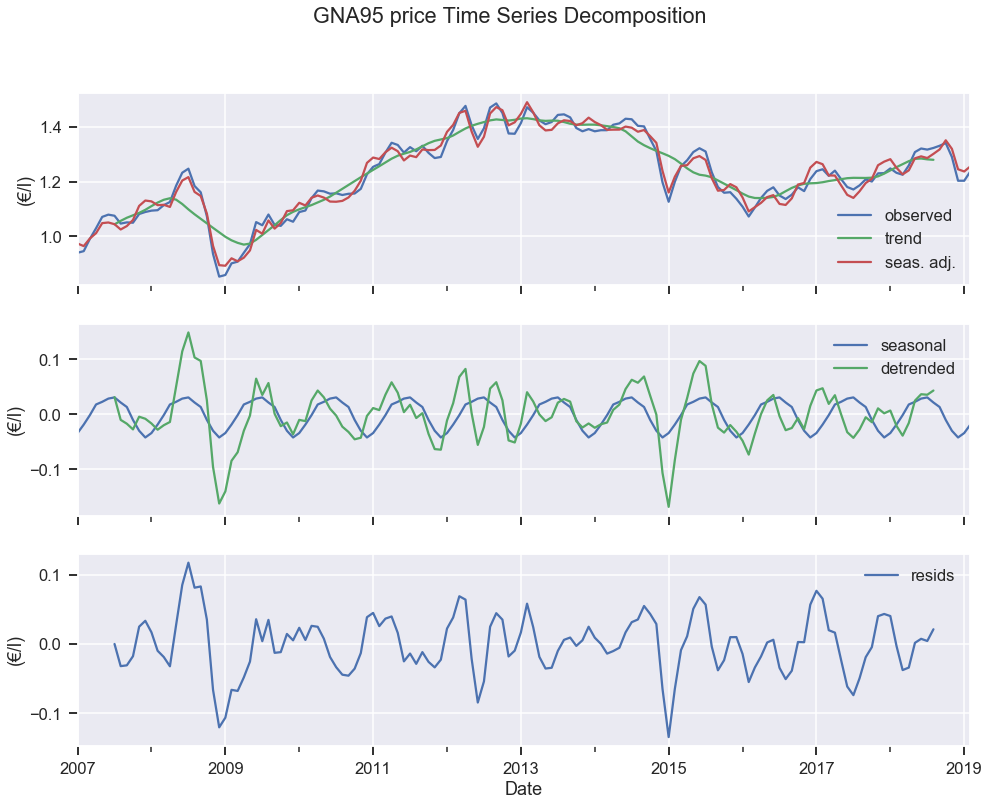

In [12]:
fig, axs = mle_tsa.plot_seas_model(seas_models['price_GNA95'], title='GNA95 price', ylabel='(€/l)')
plt.show()

# Stationarity Checking

In [13]:
adf_test_cols = ['cons_GNA95', 'cons_GNA95_pct_change1', 'cons_GNA95_seas_adj', 'cons_GNA95_seas_adj_pct_change1', 'cons_GNA95_seas_adj_diff1',
                 'cons_GNA95_diff1', 'cons_GNA95_diff1_sdiff12',
                'price_GNA95', 'price_GNA95_pct_change1', 'price_GNA95_seas_adj', 'price_GNA95_seas_adj_pct_change1', 'price_GNA95_seas_adj_diff1',
                'price_GNA95_diff1', 'price_GNA95_diff1_sdiff12',]
_ = mle_tsa.wrap_adfuller(data[adf_test_cols], regression='c')

cons_GNA95: p-value: 0.28
cons_GNA95_pct_change1: p-value: 0.47
cons_GNA95_seas_adj: p-value: 0.31
cons_GNA95_seas_adj_pct_change1: p-value: 0.56
cons_GNA95_seas_adj_diff1: p-value: 0.51
cons_GNA95_diff1: p-value: 0.51
cons_GNA95_diff1_sdiff12: p-value: 0.00
price_GNA95: p-value: 0.36
price_GNA95_pct_change1: p-value: 0.00
price_GNA95_seas_adj: p-value: 0.48
price_GNA95_seas_adj_pct_change1: p-value: 0.00
price_GNA95_seas_adj_diff1: p-value: 0.00
price_GNA95_diff1: p-value: 0.00
price_GNA95_diff1_sdiff12: p-value: 0.00


In [14]:
_ = mle_tsa.wrap_adfuller(data[['cons_GNA95_seas_adj_pct_change1']], regression='ct')

cons_GNA95_seas_adj_pct_change1: p-value: 0.14


In [15]:
_ = mle_tsa.wrap_kpss(data[['cons_GNA95_seas_adj_pct_change1']], regression='c', nlags='auto')

cons_GNA95_seas_adj_pct_change1: p-value: 0.02


C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


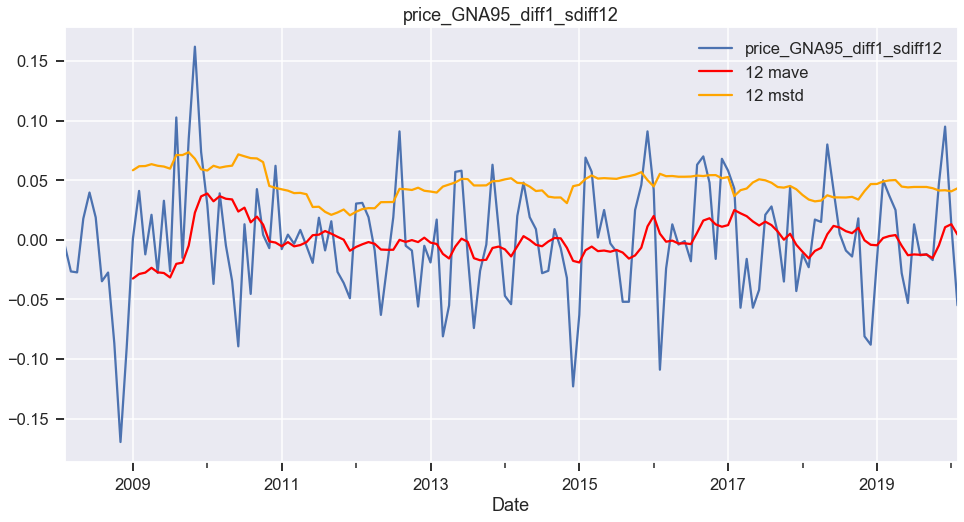

In [16]:
ax = mle_tsa.plot_time_series_with_rolling(x=data['price_GNA95_diff1_sdiff12'], period=12)

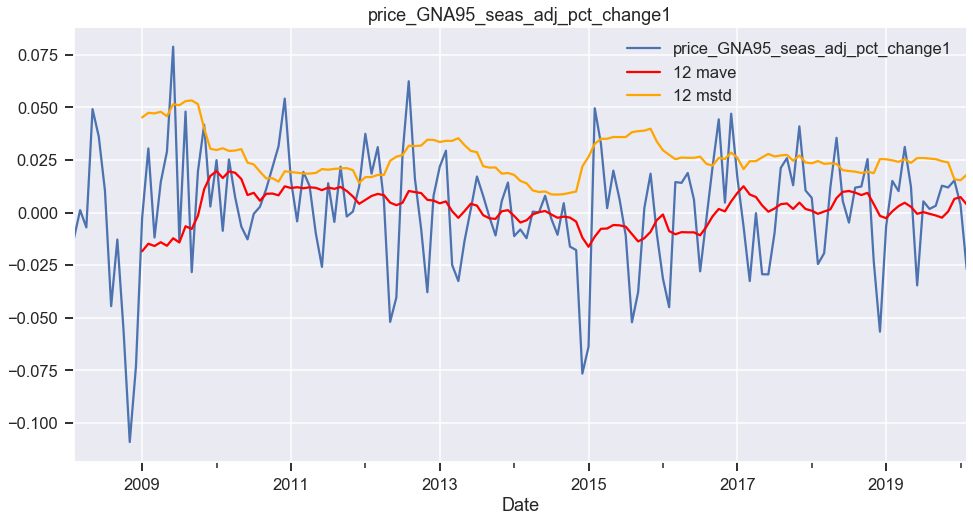

In [17]:
ax = mle_tsa.plot_time_series_with_rolling(x=data['price_GNA95_seas_adj_pct_change1'], period=12)

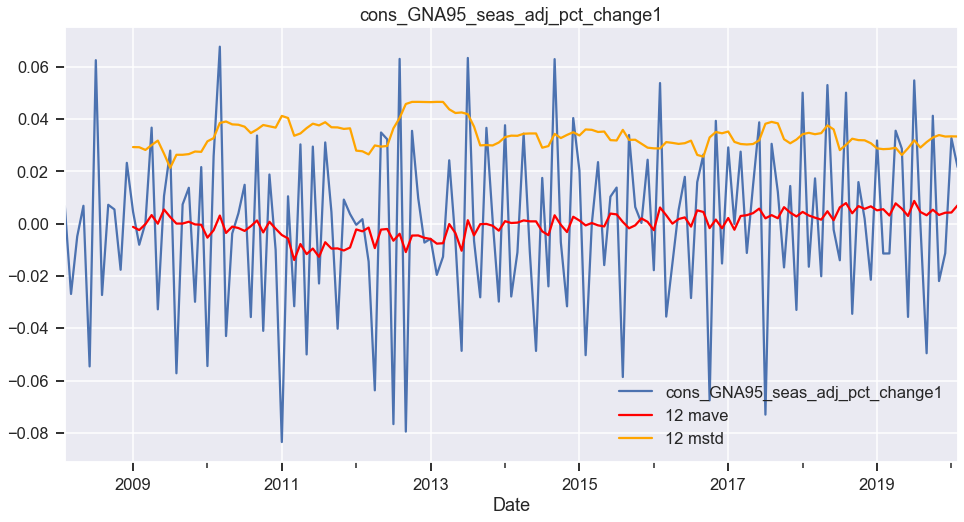

In [18]:
ax = mle_tsa.plot_time_series_with_rolling(x=data['cons_GNA95_seas_adj_pct_change1'], period=12)

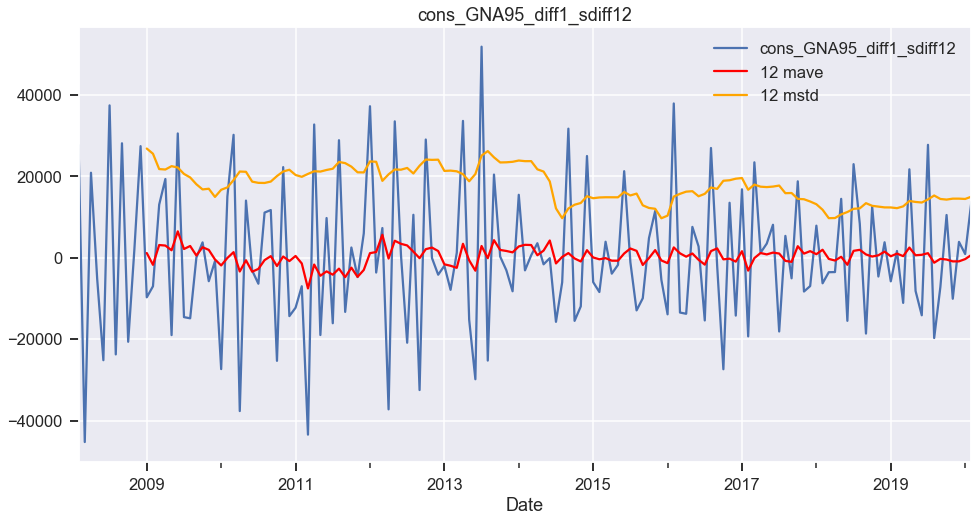

In [19]:
ax = mle_tsa.plot_time_series_with_rolling(x=data['cons_GNA95_diff1_sdiff12'], period=12)

# Autocorrelation

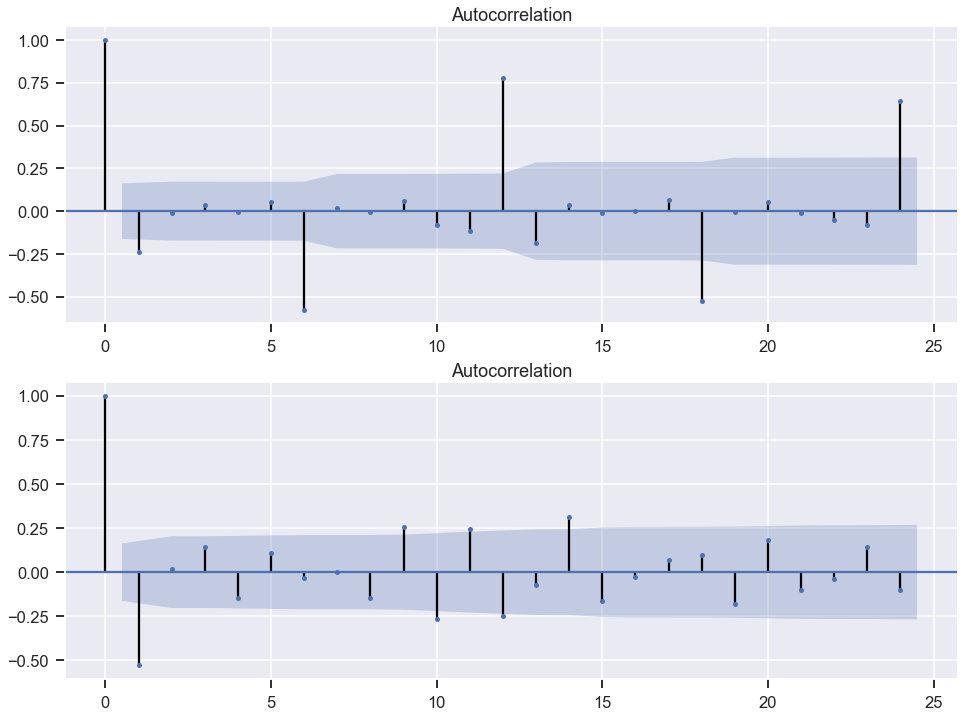

In [43]:
fig, axs   = plt.subplots(2, 1, figsize=(16,12))

plot_acf(data['cons_GNA95_diff1'], lags=24, ax=axs[0])
plot_acf(data['cons_GNA95_diff1_sdiff12'],lags=24, ax=axs[1])
plt.show()

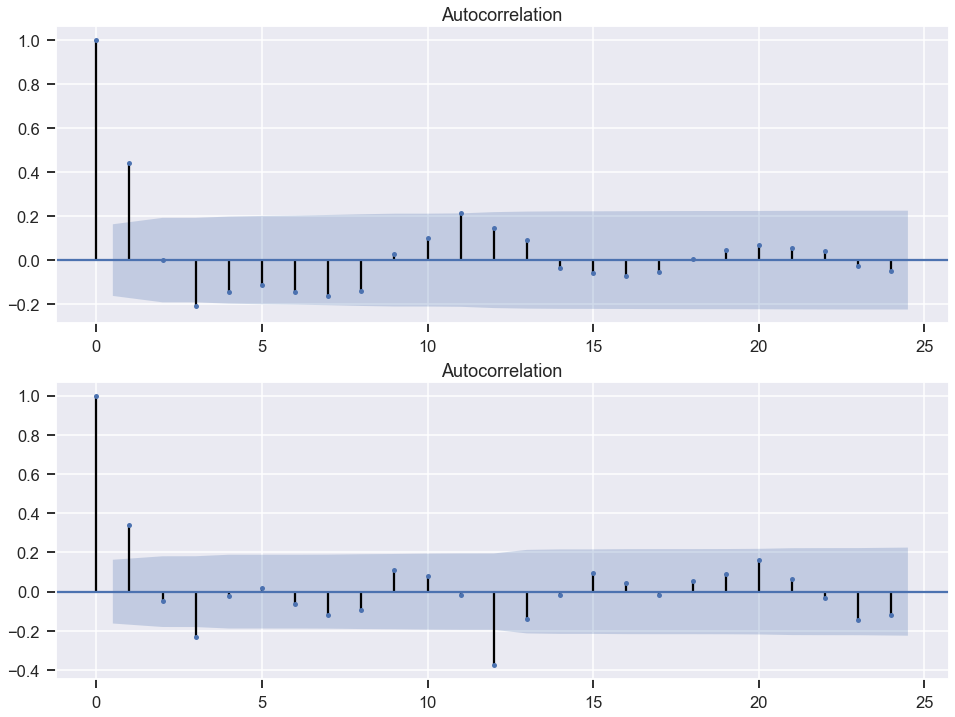

In [44]:
fig, axs   = plt.subplots(2, 1, figsize=(16,12))

plot_acf(data['price_GNA95_diff1'], lags=24, ax=axs[0])
plot_acf(data['price_GNA95_diff1_sdiff12'],lags=24, ax=axs[1])
plt.show()

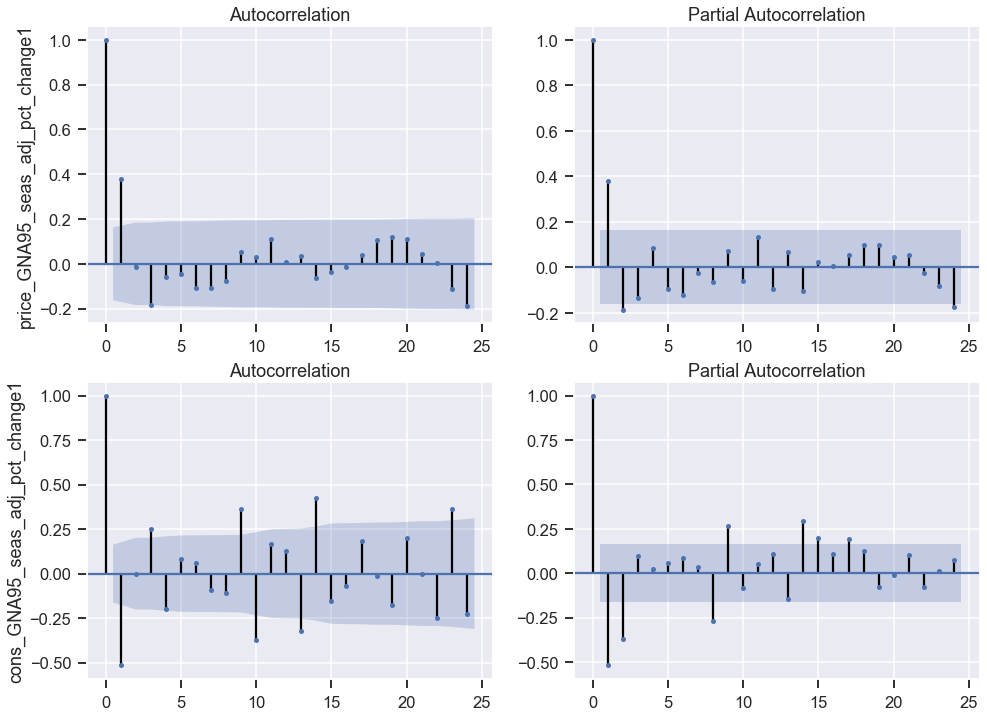

In [33]:
fig, axs   = plt.subplots(2, 2, figsize=(16,12))

for idx_row, col in enumerate(['price_GNA95_seas_adj_pct_change1', 'cons_GNA95_seas_adj_pct_change1']):
    plot_acf(data[col], lags=24, ax=axs[idx_row,0])
    plot_pacf(data[col],lags=24, ax=axs[idx_row,1])
    axs[idx_row,0].set_ylabel(col)

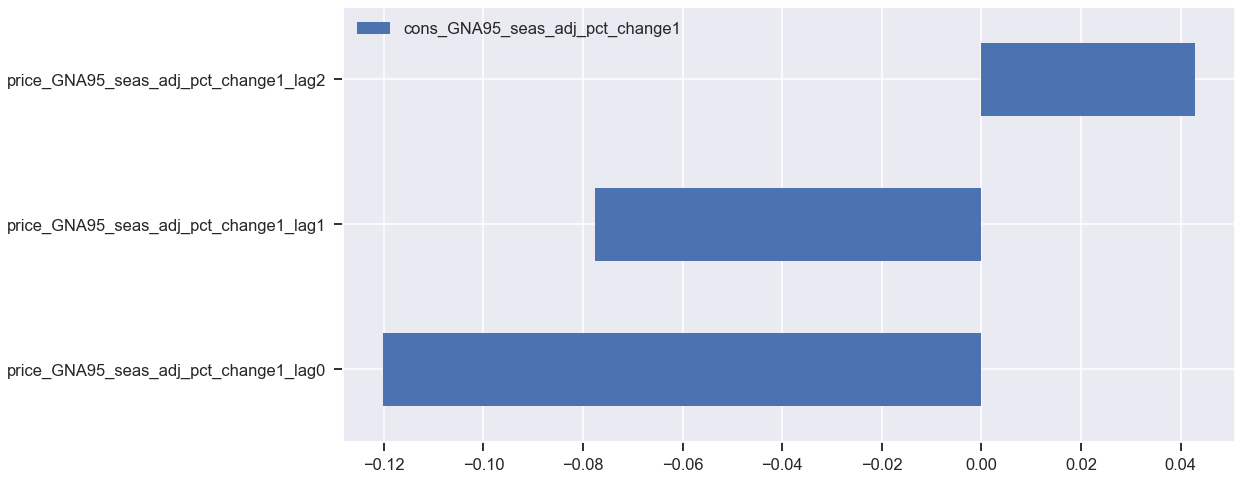

In [34]:
gna_corr = mle_tsa.pairwise_corr_over_time(data, 'price_GNA95_seas_adj_pct_change1', ['cons_GNA95_seas_adj_pct_change1'], 3)
gna_corr.plot.barh()
plt.show()

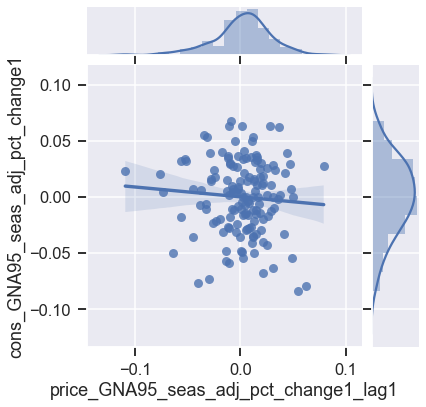

In [35]:
g = sns.jointplot('price_GNA95_seas_adj_pct_change1_lag1', 'cons_GNA95_seas_adj_pct_change1', data, kind='reg')
plt.show()

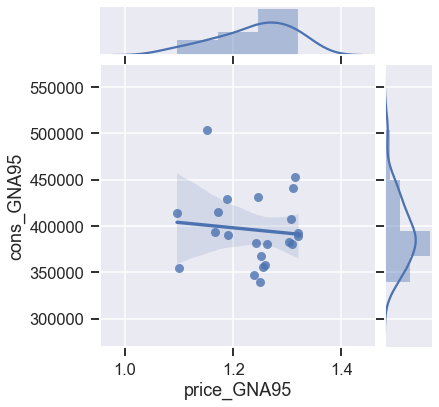

In [36]:
week_gna = data.groupby('week')[['price_GNA95', 'cons_GNA95']].median()
g = sns.jointplot('price_GNA95', 'cons_GNA95', week_gna, kind='reg')
plt.show()